# Unit 05: 應用三：製程最佳化 (Process Optimization)

**課程：化工資料科學與機器學習實務（CHE-AI-101）**

**目的：**
1. 使用 SciPy 的數值最佳化工具，尋找 CSTR 的最佳操作條件 (T, F)
2. 將物理模型 (轉化率) 與經濟模型 (利潤) 結合為一個目標函數
3. 透過等高線圖理解「利潤山」的形狀與操作穩定性

In [ ]:
# ===== Shared environment (Part_0 compatible) =====
import os, sys
from pathlib import Path

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)

def find_repo_root(start=None):
    start = Path(start or os.getcwd()).resolve()
    for p in [start] + list(start.parents):
        if (p / 'Jupyter_Scripts').is_dir():
            return p
    if IN_COLAB:
        candidate = Path('/content/drive/MyDrive/ChemEng_AI_Course_Materials')
        if (candidate / 'Jupyter_Scripts').is_dir():
            return candidate
    return start

REPO_ROOT = find_repo_root()
OUTPUT_DIR = REPO_ROOT / 'outputs'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
os.chdir(OUTPUT_DIR)
print('REPO_ROOT:', REPO_ROOT)
print('Working dir:', os.getcwd())


In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

# 設定結果儲存路徑
results_dir = 'Unit05_Results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    print(f"已建立資料夾: {results_dir}")
else:
    print(f"資料夾已存在: {results_dir}")

# 圖形設定
plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["axes.unicode_minus"] = False

已建立資料夾: Unit05_Results


## 1. 定義反應器物理與經濟模型

在此步驟中，我們定義 CSTR 的物理行為（轉化率）以及經濟效益（利潤）。
由於 `scipy.optimize` 需要呼叫函數來進行計算，我們保留這部分的函數定義。

*   **reactor_physics**: 計算給定溫度與流量下的轉化率。
*   **reactor_profit**: 計算給定條件下的淨利潤。

In [2]:
def reactor_physics(T: float, F: float) -> float:
    """
    反應器物理模型：給定溫度 T 與流量 F，計算轉化率 Conversion。
    """
    # 1. 反應速率常數 k 的簡化模型
    k = 0.5 * np.exp(0.02 * (T - 300.0))

    # 2. 停留時間 tau = V / F
    V = 100.0  # 反應器體積 [L]
    tau = V / F

    # 3. 一級反應 CSTR 轉化率 X = (k * tau) / (1 + k * tau)
    conversion = (k * tau) / (1.0 + k * tau)

    return float(conversion)

def reactor_profit(x: np.ndarray) -> float:
    """
    利潤函數 (Profit Function)
    x[0] = 溫度 T (K)
    x[1] = 進料流量 F (L/min)
    """
    T, F = x

    # 轉化率模型
    conversion = reactor_physics(T, F)

    # 經濟參數 (已調整以獲得內點解/邊界解 T~370K, F~50L/min)
    price_product = 200.0      # 產品售價 ($/mol)
    cost_raw_material = 100.0  # 原料成本 ($/mol) - 降低成本以提升高溫操作的獲利能力
    cost_energy_base = 2.5     # 能源成本係數 - 提高係數以將最佳溫度控制在 370 K 附近
    T_amb = 298.0              # 環境溫度 (K)

    # 收入與成本計算
    revenue = F * conversion * price_product
    material_cost = F * cost_raw_material
    energy_cost = cost_energy_base * max(T - T_amb, 0.0) ** 1.5

    profit = revenue - material_cost - energy_cost
    return float(profit)

print("模型函數定義完成。")

模型函數定義完成。


## 2. 設定最佳化目標

SciPy 的 `minimize` 函數是用來尋找**最小值**。為了尋找**最大利潤**，我們需要將利潤函數加上負號，變成尋找「負利潤」的最小值。

In [3]:
def objective_function(x: np.ndarray) -> float:
    """
    SciPy 使用的目標函數：回傳「負的利潤」，方便用 minimize 來做「最大化」。
    """
    return -reactor_profit(x)

## 3. 執行製程最佳化

設定操作變數的範圍與初始猜測值，並執行最佳化演算法。

*   **操作範圍 (Bounds)**:
    *   溫度 T: 300 ~ 400 K
    *   流量 F: 10 ~ 50 L/min
*   **初始猜測 (Initial Guess)**: T=300, F=10

In [4]:
print("開始執行最佳化...")

# 操作範圍（Bounds）
bounds = ((300.0, 400.0), (10.0, 50.0))

# 初始猜測
x0 = np.array([300.0, 10.0])
print(f"初始猜測：T = {x0[0]} K, F = {x0[1]} L/min")

# 執行最佳化
result = minimize(
    objective_function,
    x0,
    bounds=bounds,
    method="L-BFGS-B",
)

# 顯示結果
if result.success:
    opt_T = float(result.x[0])
    opt_F = float(result.x[1])
    max_profit = reactor_profit(result.x)

    print("\n✓ 找到最佳化結果：")
    print(f"  最佳溫度 T* = {opt_T:.2f} K")
    print(f"  最佳流量 F* = {opt_F:.2f} L/min")
    print(f"  對應利潤 Profit* = ${max_profit:.2f}")
else:
    print("× 最佳化失敗，原因：", result.message)
    opt_T, opt_F = None, None

開始執行最佳化...
初始猜測：T = 300.0 K, F = 10.0 L/min

✓ 找到最佳化結果：
  最佳溫度 T* = 369.86 K
  最佳流量 F* = 50.00 L/min
  對應利潤 Profit* = $1494.49


## 4. 利潤等高線視覺化 (Profit Landscape)

繪製溫度與流量對應的利潤等高線圖，並標示出最佳解的位置。這有助於我們理解操作變數對利潤的影響敏感度。
圖片將會儲存至 `Unit05_Results` 資料夾。

繪製等高線圖中...
✓ 圖片已儲存至: Unit05_Results/optimization_landscape.png


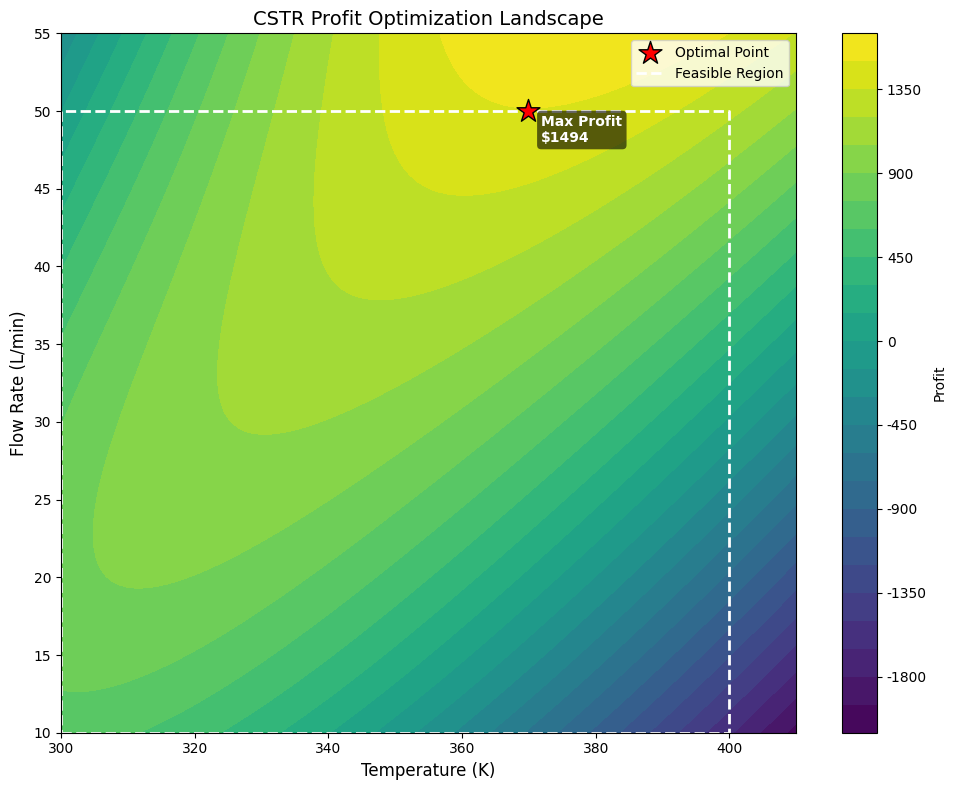

In [5]:
if opt_T is not None and opt_F is not None:
    print("繪製等高線圖中...")
    
    # 建立溫度與流量的網格
    T_range = np.linspace(300.0, 410.0, 100)
    F_range = np.linspace(10.0, 55.0, 100)
    T_grid, F_grid = np.meshgrid(T_range, F_range)

    # 計算網格上每一點的利潤
    Z = np.zeros_like(T_grid)
    for i in range(T_grid.shape[0]):
        for j in range(T_grid.shape[1]):
            Z[i, j] = reactor_profit(np.array([T_grid[i, j], F_grid[i, j]]))

    plt.figure()

    # 等高線圖
    contour = plt.contourf(T_grid, F_grid, Z, levels=25, cmap="viridis")
    plt.colorbar(contour, label="Profit")

    # 標示最佳解
    plt.scatter(
        opt_T,
        opt_F,
        color="red",
        marker="*",
        s=300,
        label="Optimal Point",
        edgecolors="black",
        zorder=10,
    )

    # 在圖上標註最佳利潤數值
    plt.text(
        opt_T + 2,
        opt_F - 2,
        f"Max Profit\n${reactor_profit(np.array([opt_T, opt_F])):.0f}",
        color="white",
        fontweight="bold",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", fc="black", ec="none", alpha=0.6),
    )

    # 畫出操作範圍的矩形邊界
    plt.plot(
        [300, 400, 400, 300, 300],
        [10, 10, 50, 50, 10],
        "w--",
        linewidth=2,
        label="Feasible Region",
    )

    plt.xlabel("Temperature (K)", fontsize=12)
    plt.ylabel("Flow Rate (L/min)", fontsize=12)
    plt.title("CSTR Profit Optimization Landscape", fontsize=14)
    plt.legend(loc="upper right")
    plt.tight_layout()

    # 儲存圖片
    save_path = os.path.join(results_dir, 'optimization_landscape.png')
    plt.savefig(save_path)
    print(f"✓ 圖片已儲存至: {save_path}")
    
    plt.show()
else:
    print("無法繪圖，因為未找到最佳解。")

## 5. 進階應用：加入品質限制 (Quality Constraints)

在實際製程中，我們通常對產品品質有嚴格要求。假設下游製程要求 **轉化率 (Conversion) 必須大於 90%**，我們該如何在滿足此限制的前提下最大化利潤？

這需要使用 `minimize` 函數中的 `constraints` 參數。SciPy 要求不等式限制的形式為 $g(x) \ge 0$。
因此，我們的限制函數定義為：
$$ \text{Conversion}(T, F) - 0.90 \ge 0 $$

In [6]:
def constraint_conversion(x):
    """
    限制條件函數：轉化率必須 >= 0.90
    SciPy 格式：回傳值必須 >= 0
    """
    T, F = x
    target_conversion = 0.90
    current_conversion = reactor_physics(T, F)
    return current_conversion - target_conversion

print("\n" + "=" * 40)
print("3. 帶有品質限制的最佳化 (Constrained Optimization)")
print("=" * 40)
print("限制條件：轉化率 >= 90%")

# 定義限制條件字典
cons = ({'type': 'ineq', 'fun': constraint_conversion})

# 重新執行最佳化
result_cons = minimize(
    objective_function,
    x0=[350.0, 20.0], # 調整初始猜測以幫助收斂
    bounds=bounds,
    constraints=cons,
    method="SLSQP" # SLSQP 方法較適合處理複雜限制
)

if result_cons.success:
    opt_T_c = result_cons.x[0]
    opt_F_c = result_cons.x[1]
    max_profit_c = reactor_profit(result_cons.x)
    final_conv = reactor_physics(opt_T_c, opt_F_c)

    print(f"✓ 限制最佳化結果：")
    print(f"  最佳溫度 T* = {opt_T_c:.2f} K")
    print(f"  最佳流量 F* = {opt_F_c:.2f} L/min")
    print(f"  轉化率 X    = {final_conv:.4f} (限制 >= 0.90)")
    print(f"  對應利潤    = ${max_profit_c:.2f}")
else:
    print("× 最佳化失敗:", result_cons.message)


3. 帶有品質限制的最佳化 (Constrained Optimization)
限制條件：轉化率 >= 90%
✓ 限制最佳化結果：
  最佳溫度 T* = 329.39 K
  最佳流量 F* = 10.00 L/min
  轉化率 X    = 0.9000 (限制 >= 0.90)
  對應利潤    = $360.34


## 6. 進階應用：能源價格靈敏度分析 (Sensitivity Analysis)

市場環境是動態的。如果**能源成本係數 (Energy Cost Base)** 發生變化，最佳操作溫度應該如何調整？
下面的程式碼將模擬能源成本從 1.0 上漲到 5.0 的情境，並畫出最佳溫度的變化趨勢。


4. 能源價格靈敏度分析 (Sensitivity Analysis)
正在計算不同能源價格下的最佳策略...
✓ 圖片已儲存至: Unit05_Results/sensitivity_analysis.png


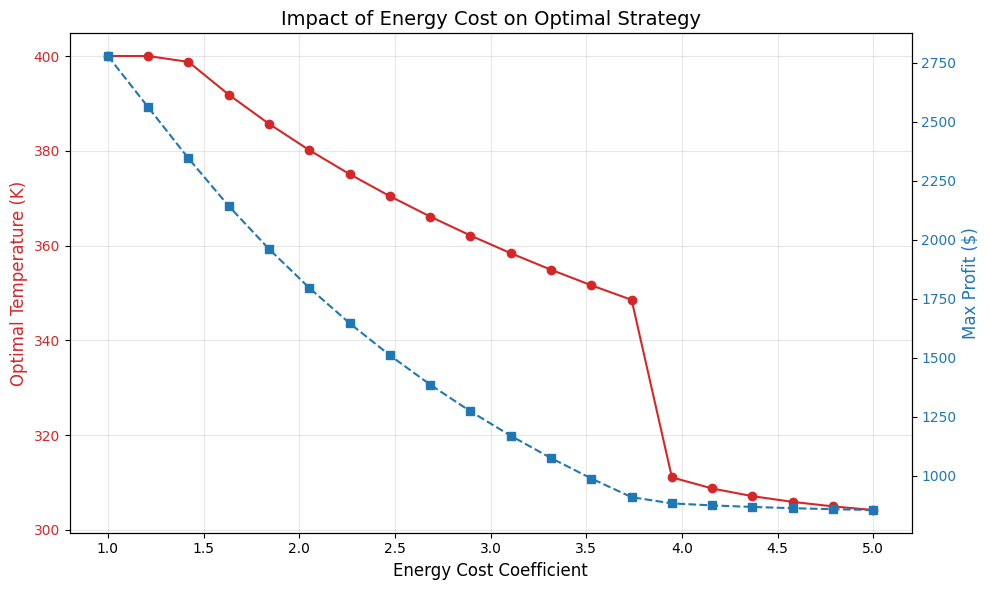

✓ 分析完成：隨著能源變貴，最佳策略是降低溫度以節省成本。


In [7]:
print("\n" + "=" * 40)
print("4. 能源價格靈敏度分析 (Sensitivity Analysis)")
print("=" * 40)

# 定義一個可變動能源成本的利潤函數
def flexible_profit(x, current_energy_cost_base):
    T, F = x
    conversion = reactor_physics(T, F)
    
    # 固定參數
    price_product = 200.0
    cost_raw_material = 100.0
    T_amb = 298.0
    
    revenue = F * conversion * price_product
    material_cost = F * cost_raw_material
    # 使用傳入的能源成本係數
    energy_cost = current_energy_cost_base * max(T - T_amb, 0.0) ** 1.5
    
    return revenue - material_cost - energy_cost

# 設定能源成本變動範圍
energy_costs = np.linspace(1.0, 5.0, 20)
optimal_temps = []
optimal_profits = []

print("正在計算不同能源價格下的最佳策略...")

for cost in energy_costs:
    # 定義當前的目標函數 (lambda 函數)
    current_obj = lambda x: -flexible_profit(x, cost)
    
    res = minimize(
        current_obj,
        x0=[350.0, 30.0],
        bounds=bounds,
        method="L-BFGS-B"
    )
    
    if res.success:
        optimal_temps.append(res.x[0])
        optimal_profits.append(flexible_profit(res.x, cost))
    else:
        optimal_temps.append(np.nan)
        optimal_profits.append(np.nan)

# 繪圖
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Energy Cost Coefficient', fontsize=12)
ax1.set_ylabel('Optimal Temperature (K)', color=color, fontsize=12)
ax1.plot(energy_costs, optimal_temps, color=color, marker='o', label='Optimal T')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()  # 共用 x 軸
color = 'tab:blue'
ax2.set_ylabel('Max Profit ($)', color=color, fontsize=12)
ax2.plot(energy_costs, optimal_profits, color=color, marker='s', linestyle='--', label='Max Profit')
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Impact of Energy Cost on Optimal Strategy", fontsize=14)
plt.tight_layout()

# 儲存圖片供講義使用
save_path_sens = os.path.join(results_dir, 'sensitivity_analysis.png')
plt.savefig(save_path_sens)
print(f"✓ 圖片已儲存至: {save_path_sens}")

plt.show()

print("✓ 分析完成：隨著能源變貴，最佳策略是降低溫度以節省成本。")